## Load Data and Initial Grid Search

In [1]:
# Assign directory
import os
BRANDON = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
YASH = '/Users/yashd/Desktop/hierarchical-bayesian-model-validation/'
HANNAH = ''
ZIXUN = ''

ROOT_DIR = YASH
os.chdir(ROOT_DIR + 'testing-framework/')

DATA_NAME = 'full-pastis-gray-wavelet'
GROUP = 'layer'
SKIP_OPTIMIZE_STEP = True

# os.mkdir(DATA_NAME)
# os.mkdir(os.path.join(DATA_NAME, "CSVs"))
# os.mkdir(os.path.join(DATA_NAME, "plots"))

In [2]:
from utilities import *
from plot_utilities import *
''' Comment out the below two lines if you do not have Matlab installed and opened'''
np.random.seed(0)

In [3]:
''' Only need to run commented code once'''
# data_df = pd.read_pickle(f'../transformed-data/{DATA_NAME}.pickle')
# min_group, max_group = 2, max(data_df[GROUP])
# group_data_map = dict()
# for group in np.arange(min_group, max_group + 1):
#     data = np.append(data_df[(data_df['orientation'] == 'H') & (data_df[GROUP] == group)]['data'].iloc[0],
#                      data_df[(data_df['orientation'] == 'V') & (data_df[GROUP] == group)]['data'].iloc[0])
#     group_data_map[group] = np.sort(data)#[np.round(np.linspace(0, data.size - 1, min(data.size, 100000))).astype(int)] 
# pd.to_pickle(group_data_map, f'{DATA_NAME}/group_data_map.pickle')


group_data_map = pd.read_pickle(f'approx1e5-{DATA_NAME}/group_data_map.pickle')
min_group, max_group = 2, sorted(group_data_map)[-1]
cdfs_list = [i for i in os.listdir("CDFs/")]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
group_data_map

{2: array([-99.93568594, -91.00645124, -88.54430615, ...,  88.80035968,
         91.52850405,  94.44944672]),
 3: array([-76.13432886, -63.02074639, -60.52416619, ...,  65.19608846,
         65.26965934,  69.44498554]),
 4: array([-51.73647153, -48.46756551, -45.83266202, ...,  48.25087164,
         50.33643736,  64.88734264]),
 5: array([-47.95678457, -36.2290875 , -34.21402956, ...,  32.91894773,
         36.11999915,  42.17747737]),
 6: array([-23.87540781, -21.69502371, -19.77842932, ...,  18.532206  ,
         21.00124659,  44.79754701]),
 7: array([-19.12997336, -11.63154378, -10.24156022, ...,  10.34018388,
         11.58181396,  20.30569957]),
 8: array([-18.71256003,  -5.38310051,  -4.75432793, ...,   4.71546986,
          5.46900035,  20.5891778 ])}

In [4]:
''' Only need to run commented code once'''
all_cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(all_cdfs.items())})
all_cdfs_df['r'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[0])
all_cdfs_df['eta'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[1])
all_cdfs_df['cdf'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[1])
all_cdfs_df['variance'] = np.nan_to_num(all_cdfs_df.apply(lambda row : variance_prior(row.loc['r'], row.loc['eta']), axis = 1))
all_cdfs_df['kurtosis'] = all_cdfs_df.apply(lambda row : kurtosis_prior(row.loc['r'], row.loc['eta']), axis = 1)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
group_cdf_df_dict = dict()

all_cdfs_df.head()

c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:783: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:788: RuntimeWarning: overflow encountered in scalar power
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:788: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:788: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.ga

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, 0), <scipy.interpolate._fitpack2.Inter...",0.02,0.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,4.553186e+99,NaN
1,"((0.02, 0.1), <scipy.interpolate._fitpack2.Int...",0.02,0.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.560477e+100,NaN
2,"((0.02, 0.2), <scipy.interpolate._fitpack2.Int...",0.02,0.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,6.013272e+101,NaN
3,"((0.02, 0.3), <scipy.interpolate._fitpack2.Int...",0.02,0.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.824903e+102,NaN
4,"((0.02, 0.4), <scipy.interpolate._fitpack2.Int...",0.02,0.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.104347e+103,NaN


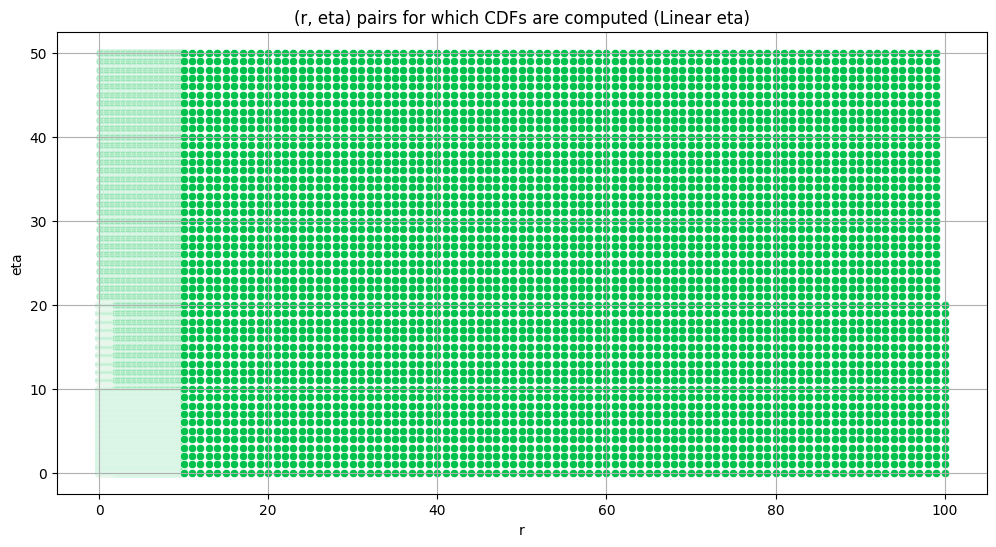

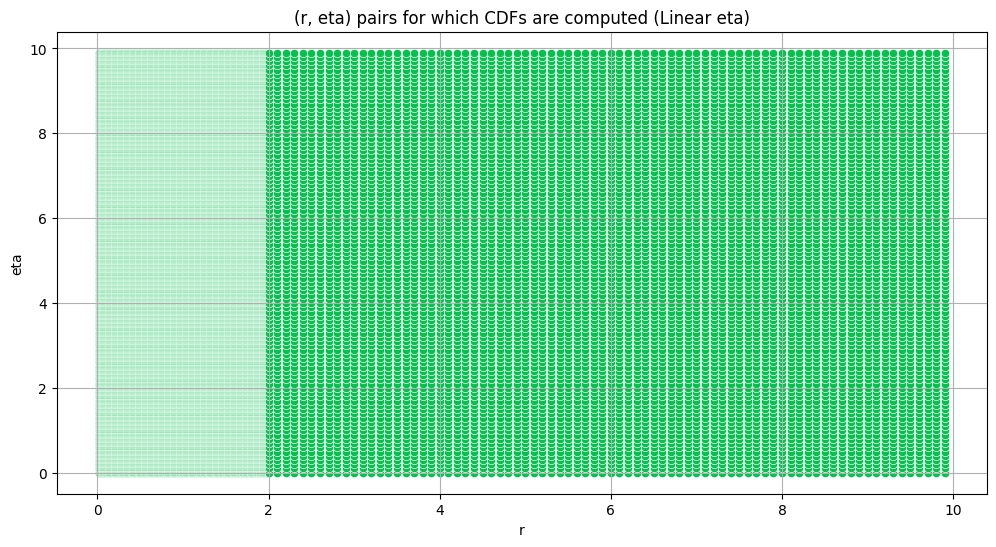

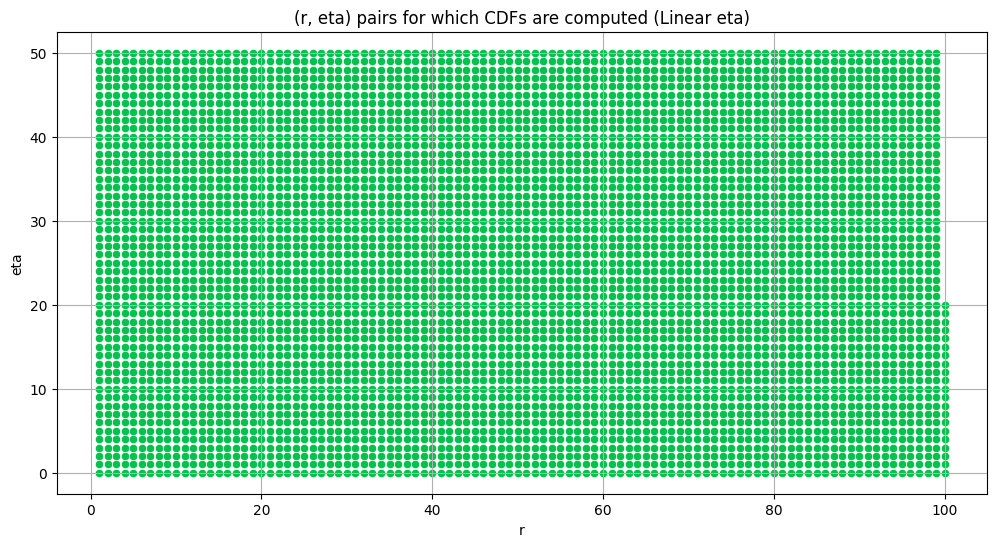

c:\Users\yashd\.conda\envs\hbmv\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\yashd\.conda\envs\hbmv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,r,eta,variance,kurtosis
count,38527.000000,38527.000000,3.852700e+04,3.766100e+04
mean,8.890484,10.478625,inf,inf
std,19.325844,11.651395,inf,NaN
min,0.020000,0.000000,0.000000e+00,1.367588e-03
25%,0.860000,3.200000,9.899464e-01,7.178904e-02
50%,1.700000,6.600000,2.040252e+00,2.490735e-01
75%,6.400000,10.000000,9.843820e+00,6.120586e-01
max,100.000000,50.000000,1.797693e+308,inf


In [5]:
create_scatter_plot(all_cdfs_df)
create_scatter_plot(all_cdfs_df[(all_cdfs_df['r'] < 10) & (all_cdfs_df['eta'] < 10)])
create_scatter_plot(coarse_cdf_df)

all_cdfs_df.describe()

In [6]:
def create_ci_scatter_plot(group_cdf_df, values_dict, metric='variance', group=None):
    ci_levels = [50, 80, 95, 99, 99.9, 99.99]
    thresholds = [np.percentile(values_dict[group], [(100 - ci)/2, ci/2]) for ci in ci_levels]

    fig, ax = plt.subplots(figsize=(8, 6))
    cmap = plt.get_cmap('viridis')
    norm = mcolors.Normalize(vmin=0, vmax=len(ci_levels))

    scatter_collection = []
    for i, (lower, upper) in enumerate(reversed(thresholds)):
        mask = (group_cdf_df[metric] >= lower) & (group_cdf_df[metric] <= upper)
        color = cmap(norm(i))
        scatter = ax.scatter(group_cdf_df.loc[mask, 'r'], group_cdf_df.loc[mask, 'eta'], 
                   c=[color], s=20, alpha=0.7, label=f'{ci_levels[-(i+1)]}% CI')
        scatter_collection.append(scatter)

    ax.set_xlabel('r')
    ax.set_ylabel('eta')
    ax.set_title(f'{metric.capitalize()} Scatter Plot for {group}')

    plt.legend()
    plt.show()
    return fig


 Layer 2


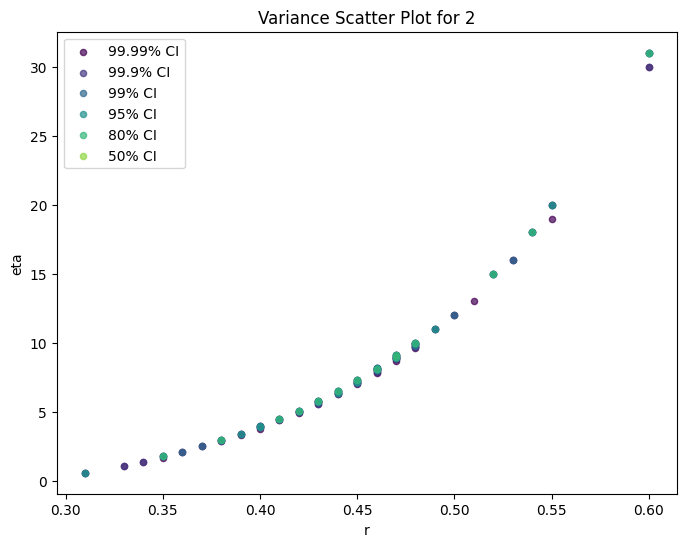

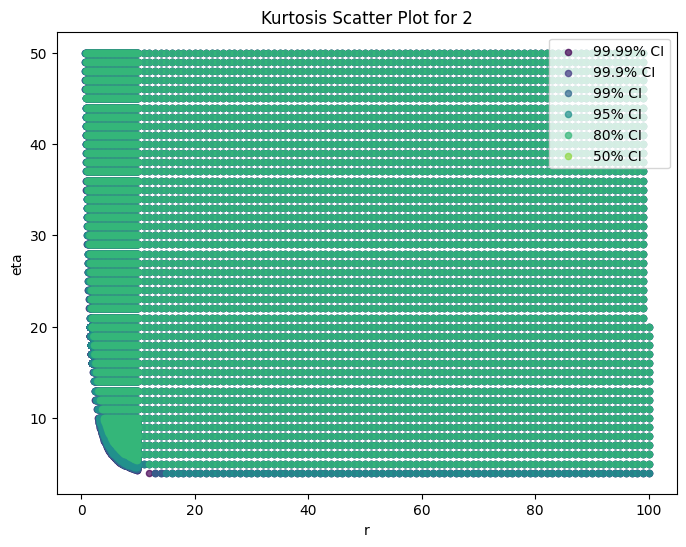


 Layer 3


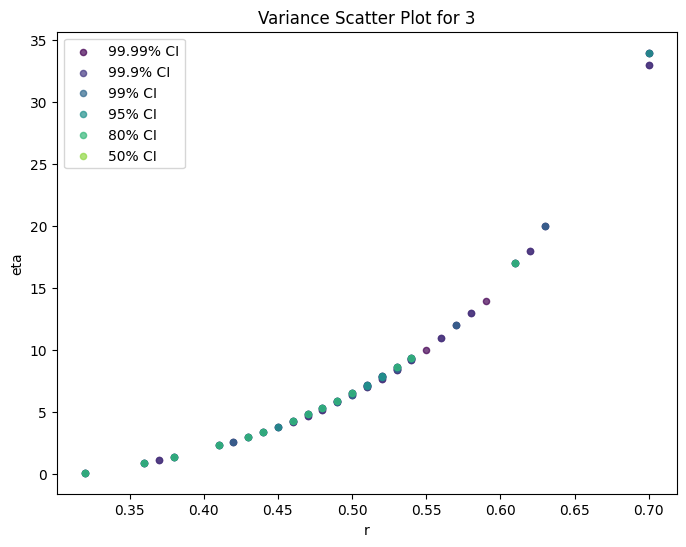

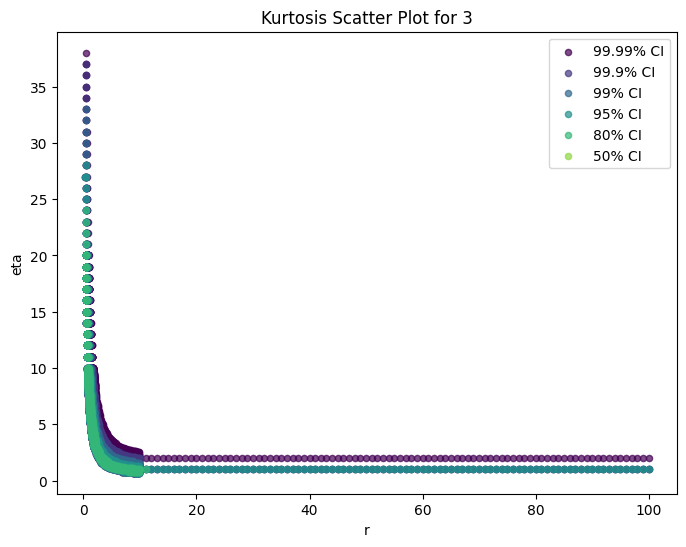


 Layer 4


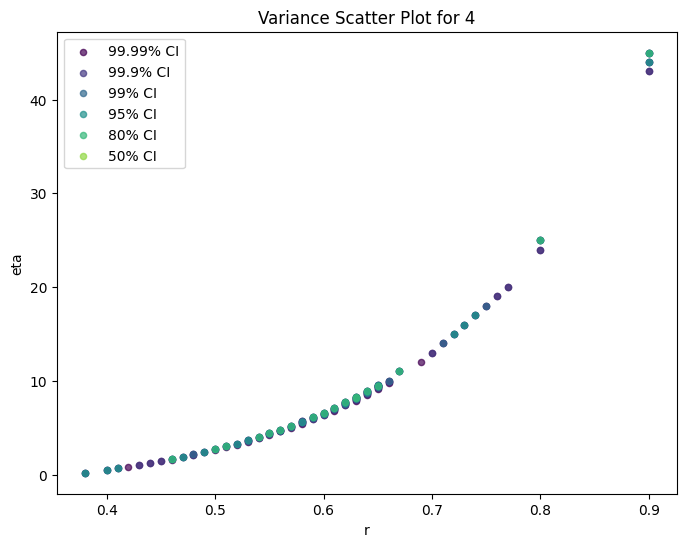

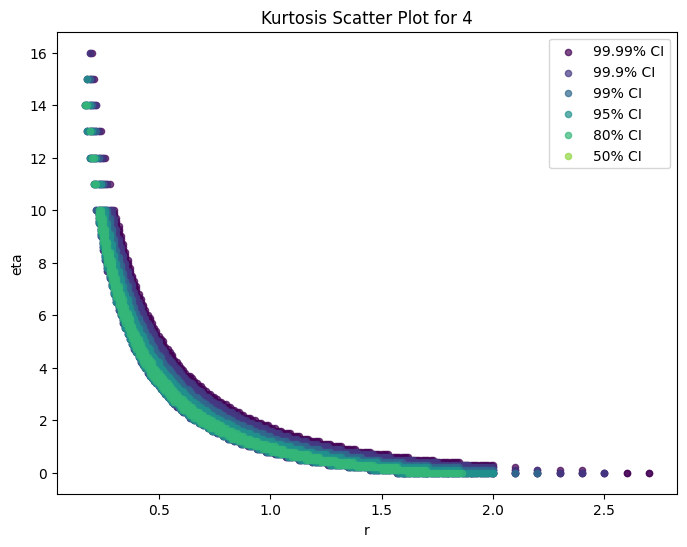


 Layer 5


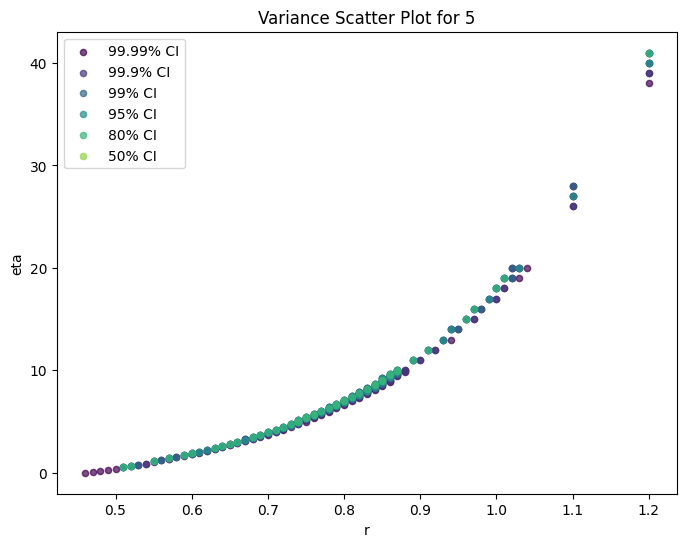

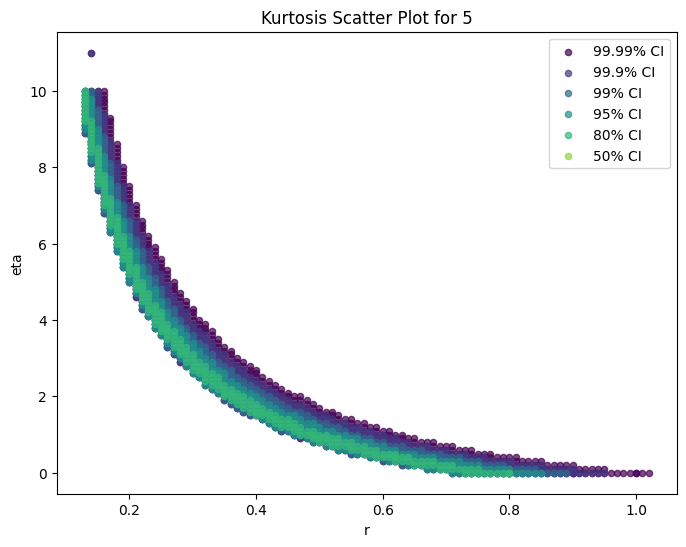


 Layer 6


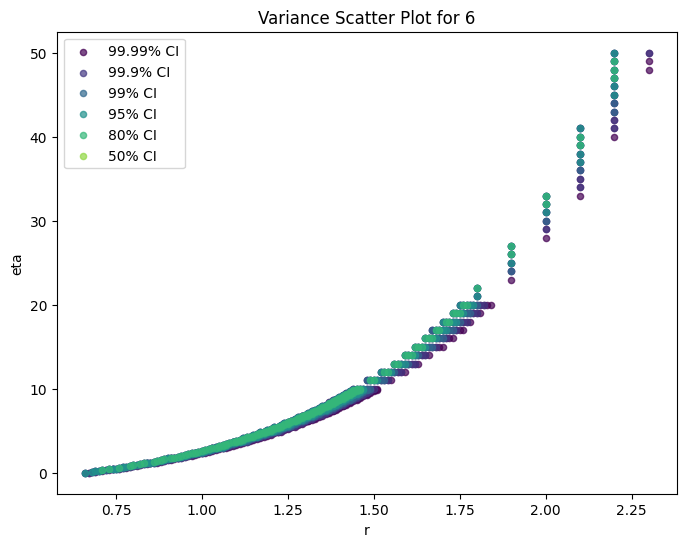

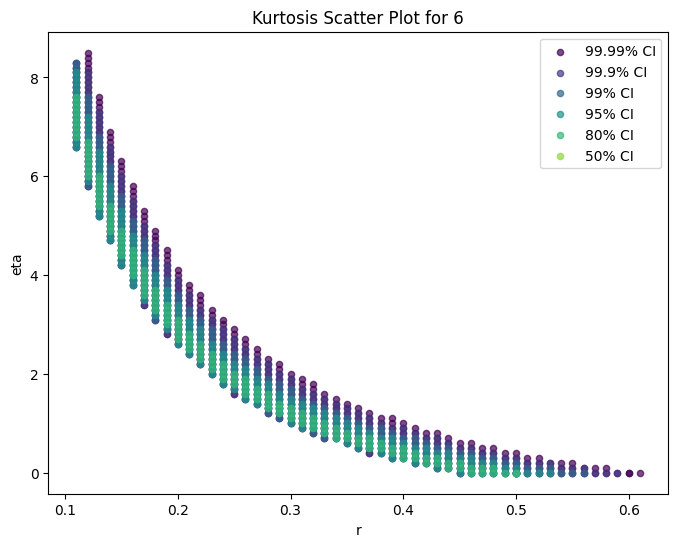


 Layer 7


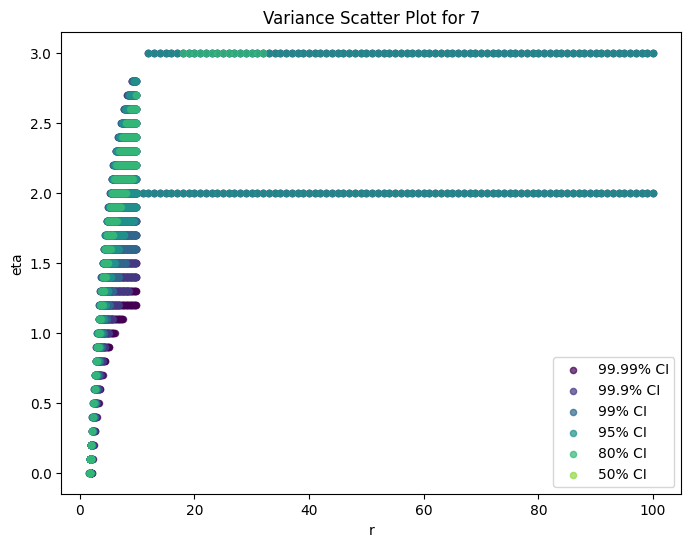

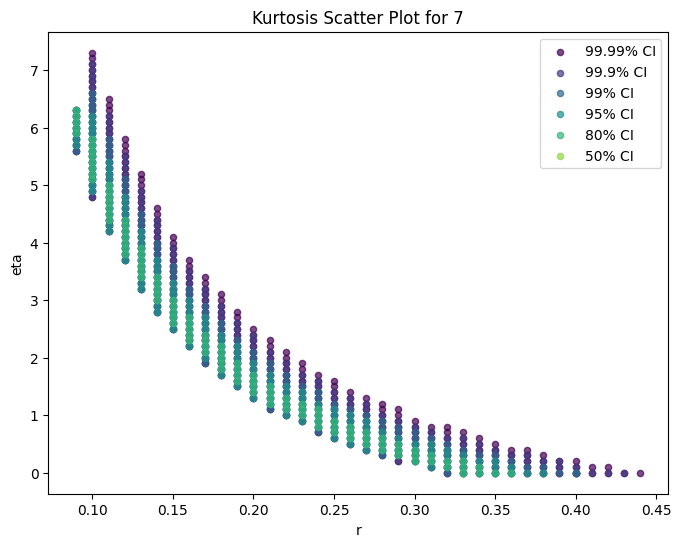


 Layer 8


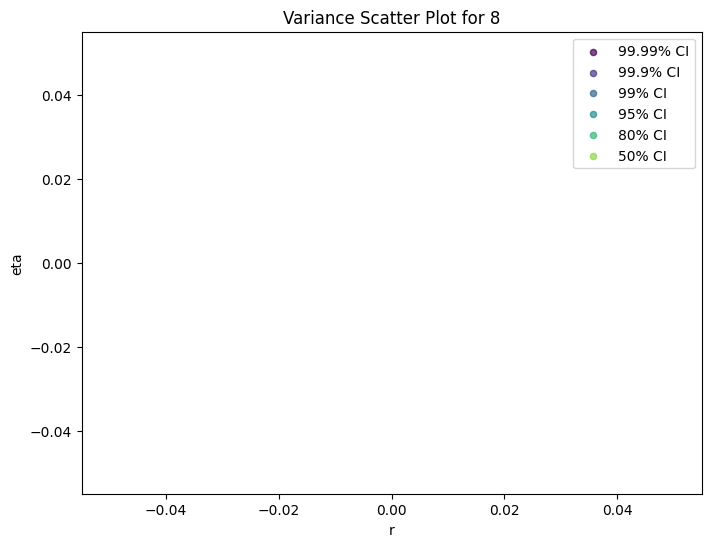

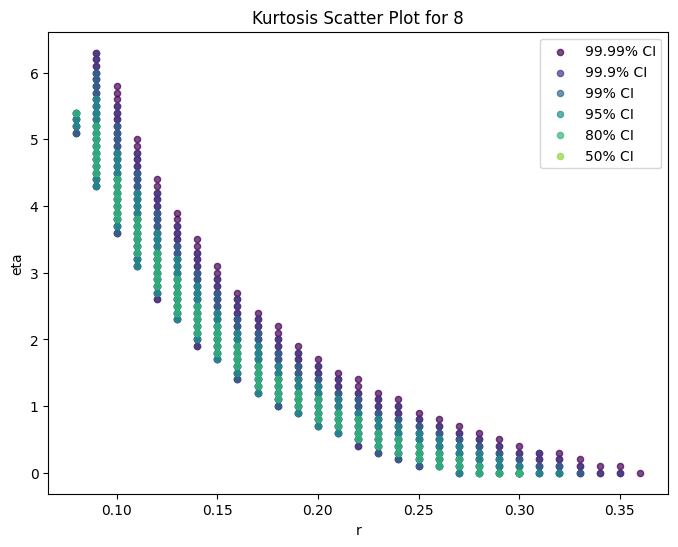

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper
layer,,,,,,
2,803.473892,736.385029,872.102147,0.094996,-0.146829,0.362276
3,275.270192,261.649192,289.410296,0.374403,0.183631,0.595734
4,80.847728,75.975027,85.694408,1.357251,0.954575,2.049270
5,19.882305,18.476825,21.396311,3.074957,2.084542,5.844440
6,4.187365,3.812586,4.732310,7.592764,3.603499,45.300214
7,0.819285,0.729973,0.952453,13.123555,5.564446,60.728159
8,0.136744,0.114494,0.247803,172.661568,7.452769,829.748144


In [7]:
''' Only need to run commented code once'''
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.999
eps_var = 50
eps_kurt = 5
    
for group in np.arange(min_group, max_group+1):
    print(f'\n {GROUP.capitalize()} {group}')
    obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], n_bootstrap=n_bootstrap, bootstrap_size=min(group_data_map[group].size, bootstrap_size), metric= np.var, ci=ci)
    obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], n_bootstrap=n_bootstrap, bootstrap_size=min(group_data_map[group].size, bootstrap_size), metric= stats.kurtosis, ci=ci)  
    group_cdf_df = all_cdfs_df.copy()
    group_cdf_df['pass_var'] = (group_cdf_df['variance'] > var_lower) & (group_cdf_df['variance'] < var_upper)
    group_cdf_df['pass_kurt'] = (group_cdf_df['kurtosis'] > kurt_lower) & (group_cdf_df['kurtosis'] < kurt_upper)
    group_cdf_df['pass_eps_var'] = (group_cdf_df['variance'] > var_lower - eps_var) & (group_cdf_df['variance'] < var_upper + eps_var)
    group_cdf_df['pass_eps_kurt'] = (group_cdf_df['kurtosis'] > kurt_lower - eps_kurt) & (group_cdf_df['kurtosis'] < kurt_upper + eps_kurt)

    master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
    master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
    group_cdf_df_dict[group] = group_cdf_df
    fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
    fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

    fig_var.savefig(f'{DATA_NAME}/plots/ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.png', bbox_inches='tight')
    plt.close(fig_var)
    fig_kurt.savefig(f'{DATA_NAME}/plots/ci_scatter_kurtosis_{GROUP}_{group}_bootstrap{n_bootstrap}.png', bbox_inches='tight')
    plt.close(fig_kurt)

pd.to_pickle(var_values_dict, f'{DATA_NAME}/var_values_dict_{n_bootstrap}_{bootstrap_size}.pickle')
pd.to_pickle(kurt_values_dict, f'{DATA_NAME}/kurt_values_dict_{n_bootstrap}_{bootstrap_size}.pickle')
master_df.to_csv(f'{DATA_NAME}/CSVs/initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv')
pd.to_pickle(group_cdf_df_dict, f"{DATA_NAME}/group_cdf_df_dict_initial.pickle")

group_cdf_df_dict = pd.read_pickle(f"{DATA_NAME}/group_cdf_df_dict_initial.pickle")
master_df = pd.read_csv(f'{DATA_NAME}/CSVs/initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv', index_col=GROUP)
master_df

In [17]:
def gen_gamma_mean(r, eta):
    return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)

def gen_gamma_variance(r, eta):
    mean = gen_gamma_mean(r, eta)
    second_moment = scipy.special.gamma((eta+3.5)/r) / scipy.special.gamma((eta+1.5)/r)
    return second_moment - mean**2

def find_eta_for_target_mean(r, target_mean):
    def objective(eta):
        return (gen_gamma_mean(r, eta) - target_mean)**2
    result = scipy.optimize.minimize_scalar(objective)
    return result.x

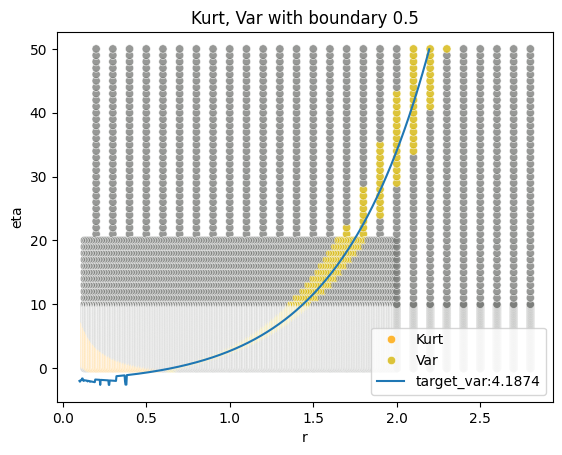

-1.841454311860046


<Axes: title={'center': 'Kurt, Var with boundary 0.5'}, xlabel='r', ylabel='eta'>

In [121]:
def combo_map_plot(df, cols, extra_boundary = 0.5, plot_name = '', target_var = None):
    cols = sorted(cols)
    df = df.copy() 
    for col in cols:
        df[col] = df[col].replace({True: col[5:], False: ''})
    df['map'] = df.apply(lambda row : ''.join([row.loc[col].capitalize() +'' for col in cols]), axis = 1)
    temp = df[(df['map'] != '') & (df['map'] != 'Kurt')]
    df = df[(df['r'] >= temp['r'].min() - extra_boundary) & 
            (df['r'] <= temp['r'].max() + extra_boundary) &
            (df['eta'] >= temp['eta'].min() - extra_boundary) & 
            (df['eta'] <= temp['eta'].max() + extra_boundary)]
    fixed_palette = {
    'Var': 'xkcd:dark yellow',
    'Kstest': 'blue',
    'Kurt': 'orange',
    'KstestVar': 'cyan',
    'KurtVar': 'red',
    'KstestKurt': 'brown',
    'KstestKurtVar': 'xkcd:shamrock green',
    '': 'xkcd:medium gray'
}
    fig, ax = plt.subplots()
    fig = sns.scatterplot(df, x='r', y='eta', hue='map', palette = fixed_palette, ax=ax, alpha=0.8)
    r_vals = []
    eta_vals = []
    if target_var:
        for r in np.linspace(0.1, df['r'].max() if df.shape[0] > 0 else 100, 1000):
            eta = find_eta_for_target_mean(r, target_var)
            if eta > df['eta'].max():
                break
            r_vals.append(r)
            eta_vals.append(eta)
        sns.lineplot(x=r_vals, y=eta_vals, label=f'target_var:{np.round(target_var, 4)}', ax=ax)

    plt.legend(loc = 'lower right')
    if plot_name:
        plt.title(plot_name)
    else:
        plt.title(f"{', '.join([col[5:].capitalize() for col in cols])} with boundary {extra_boundary}")
    plt.show()
    print(eta_vals[5])
    return fig

#combo_map_plot(group_cdf_df_dict[2], ['pass_var','pass_kurt'])
group = 6
combo_map_plot(group_cdf_df_dict[group], ['pass_var','pass_kurt'], target_var = master_df.loc[group, 'obs_var'])

Variance:0.08560883384514449, Target Variance: 0.1367438340943053
Variance of parameters with eta = 0:0.08560883384514449
Chebyshev bound: 17.756297580213776
No tail


100%|██████████| 250/250 [00:02<00:00, 110.94it/s]


First CDF value: 7.805186259695772e-54
Last CDF value: 1.0
Tail bound: 0.001


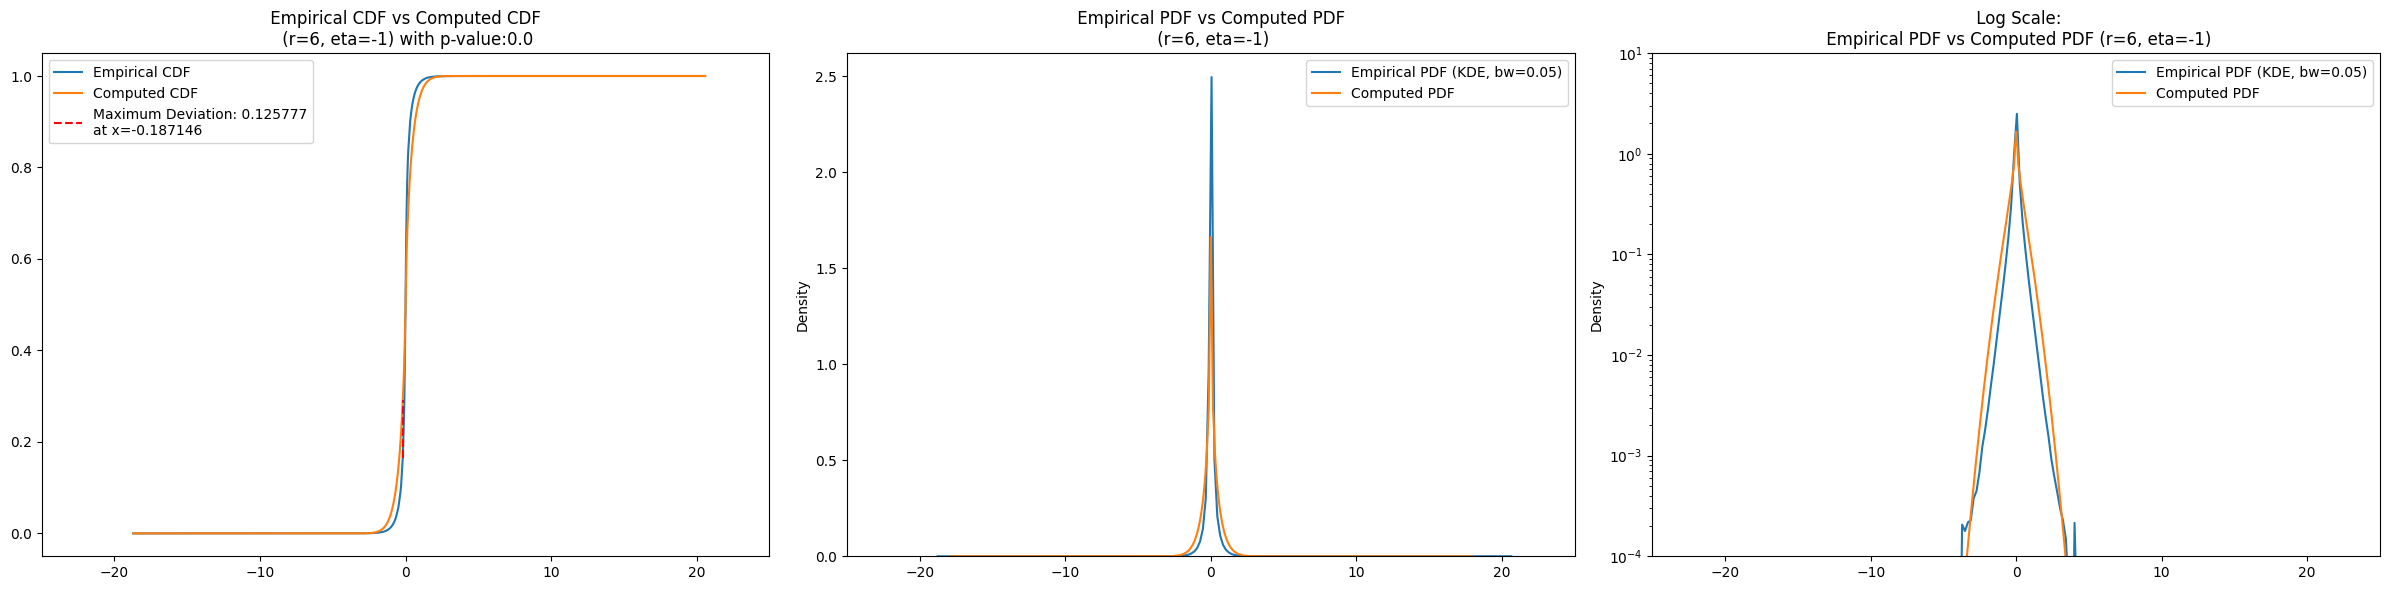

Chebyshev bound: 24.22423497919929
No tail


100%|██████████| 250/250 [00:02<00:00, 116.60it/s]


First CDF value: 1.7364613297819017e-88
Last CDF value: 1.0
Tail bound: 0.001


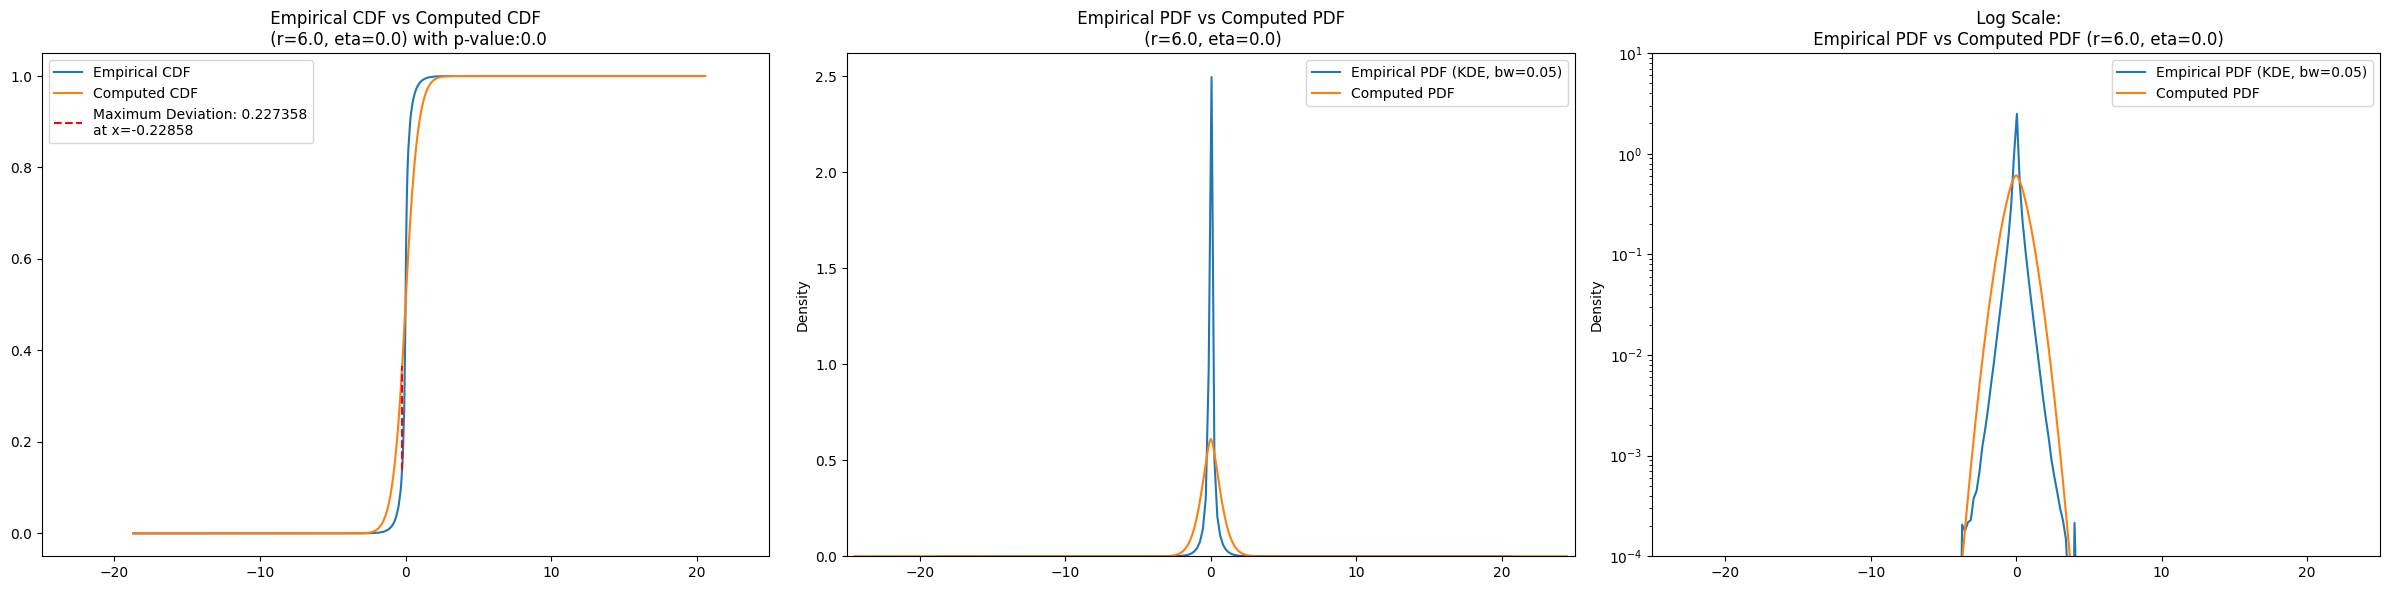

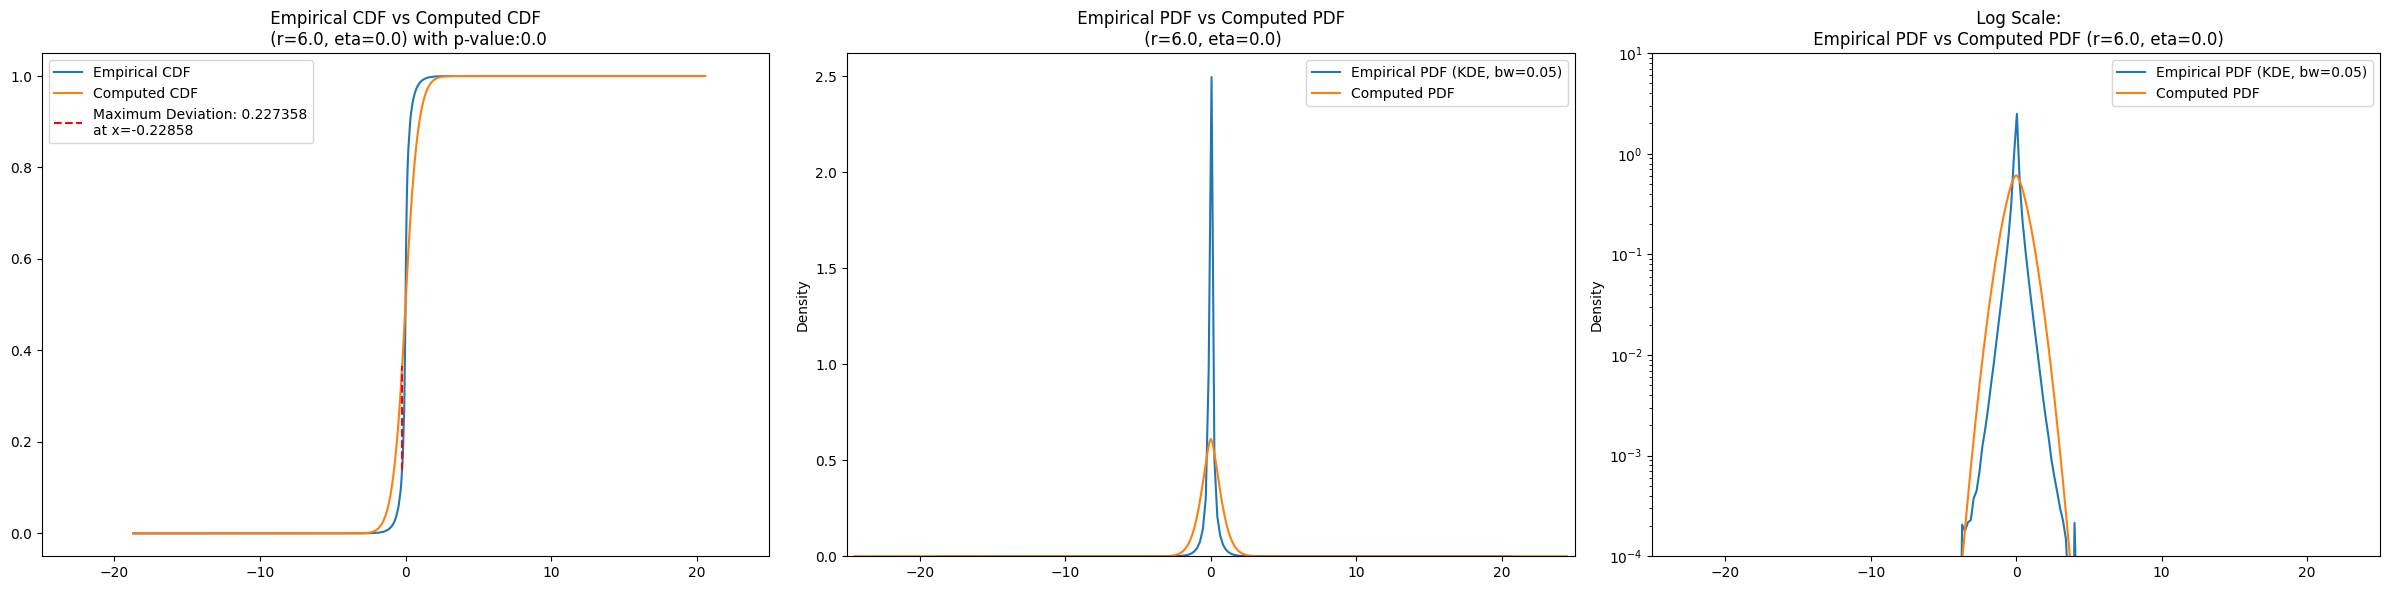

In [125]:
test_r, test_eta = 6, -1
print(f"Variance:{gen_gamma_variance(test_r, test_eta)}, Target Variance: {master_df.loc[8, 'obs_var']}")
print(f"Variance of parameters with eta = 0:{gen_gamma_variance(test_r, test_eta)}")
visualize_cdf_pdf(sample=group_data_map[8], params=[test_r, test_eta], n_samples=500)
visualize_cdf_pdf(sample=group_data_map[8], params=[master_df.loc[8, 'initial_r'], master_df.loc[8, 'initial_eta']], n_samples=500)

In [41]:
''' Only need to run commented code once'''
sorted_params = sorted(all_cdfs)
full_group_data_map = pd.read_pickle(f'{DATA_NAME}/group_data_map.pickle')

for i, group in enumerate(np.arange(8, max_group+1)):
    print(f"####\n{GROUP.capitalize()} ", group)
    sample = group_data_map[group]
    print(f"Number of samples: {sample.size}")
    group_cdf_df = group_cdf_df_dict[group]
    ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True)
    master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
    master_df.loc[group, 'num_samples'] = full_group_data_map[group].size
    master_df.loc[group, 'kstest_stat_initial'] = min_stat
    cutoff = stats.kstwo(n=sample.size).isf(0.05)
    master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff
    group_cdf_df['ksstat'] = ksstats
    group_cdf_df['pass_kstest'] = group_cdf_df['ksstat'].apply(lambda x: True if x < cutoff else False)
    group_cdf_df_dict[group] = group_cdf_df
    cols = ['pass_var', 'pass_kstest', 'pass_kurt']

    fig = combo_map_plot(group_cdf_df_dict[group], cols, plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", target_var = master_df.loc[group, 'obs_var'])
    fig.figure.savefig(f'{DATA_NAME}/plots/full_grid_search_combo_plot_layer{group}.png', bbox_inches = 'tight', dpi=600)

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_combo.csv')
pd.to_pickle(group_cdf_df_dict, f"{DATA_NAME}/group_cdf_df_dict_full.pickle")

group_cdf_df_dict = pd.read_pickle(f"{DATA_NAME}/group_cdf_df_dict_full.pickle")
master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_combo.csv', index_col=GROUP)
master_df

####
Layer  8
Number of samples: 100000


 33%|███▎      | 12888/38527 [03:09<06:17, 67.90it/s]


KeyboardInterrupt: 

In [35]:
for i, group in enumerate(np.arange(min_group, max_group+1)):
    group_cdf_df = group_cdf_df_dict[group]
    master_df.loc[group, 'initial_r'] = group_cdf_df.loc[group_cdf_df['ksstat'].idxmin()]['r']
    master_df.loc[group, 'initial_eta'] = group_cdf_df.loc[group_cdf_df['ksstat'].idxmin()]['eta']
    print(group_cdf_df.loc[group_cdf_df['ksstat'].idxmin()]['r'])


0.42
0.51
0.44
0.47
0.74
6.1
6.0


In [20]:
''' Only need to run commented code once'''
best_params_eta0 = []
for i, group in enumerate(np.arange(min_group, max_group+1)):
    if master_df.loc[group, 'initial_eta'] != 0:
        sample = group_data_map[group]
        group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
        group_cdfs = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
        ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, group_cdfs)
        best_params_eta0.append(best_param_eta0)
        master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
    else:
        master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
        best_params_eta0.append((master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']))
master_df['best_param_eta0'] = best_params_eta0
master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_eta0.csv')

master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_eta0.csv', index_col=GROUP)
master_df

KeyError: 'initial_param'

In [ ]:
def generate_func(sample, distro, *args, n_samples=500):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, use_matlab=True, eng=eng)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, use_matlab=True, eng=eng)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, use_matlab=True, eng=eng, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior', 't'")

In [ ]:
for i, group in enumerate(np.arange(min_group, max_group+1)):
    print("Initial param:", initial_param)
    bounds = np.array(list(zip(initial_param - 0.1, initial_param + 0.1))) 
    bounds = np.where(bounds < 0, 0, bounds)
    print("Bounds:", bounds)
    result = scipy.optimize.minimize(generate_func(group_data_map[group], distro='prior'),
                                        x0=initial_param, 
                                        bounds=bounds)
    print(result)
    best_r, best_eta = result.x[0], result.x[1]
    if result.fun <  master_df.loc[group, 'kstest_stat_initial']:
        master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = best_r, best_eta
        master_df.loc[group, 'kstest_stat_best'] = result.fun
    else:
        master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_param']
        master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
    print(f"% Reduction: {(master_df['kstest_stat_initial'] - result.fun)*100/result.fun}%")

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_optimize.csv')

master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_optimize.csv', index_col=GROUP)
master_df

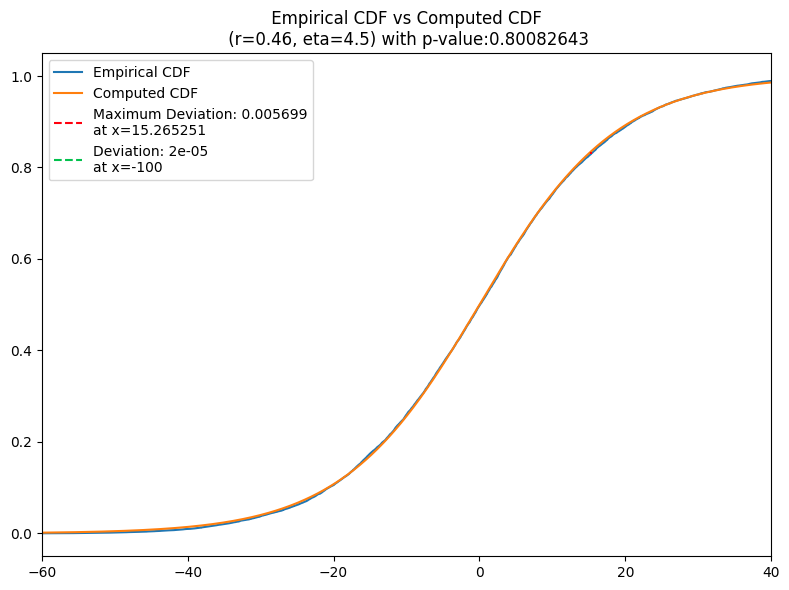

In [ ]:
group = 3
visualize_cdf(group_data_map[group], 
              all_cdfs = all_cdfs, 
              params= master_df.loc[group, 'initial_param'], 
              n_samples=10000, 
              interval = (-60, 40), 
              provided_loc = -100);

In [ ]:
# r_d, eta_d = 3, 2 # Controls precision to which parameters are optimized
# SKIP_OPTIMIZE_STEP = True

# if SKIP_OPTIMIZE_STEP:
#     r_d, eta_d = 2, 1
#     master_df['kstest_stat_cd'] = master_df['kstest_stat_initial']
#     master_df[f'best_r_d{r_d}'] = master_df['initial_param'].apply(lambda x : x[0])
#     master_df[f'best_eta_d{eta_d}'] = master_df['initial_param'].apply(lambda x : x[1])

# else:
#     for group in np.arange(min_group, max_group+1): 
#         sample = group_data_map[group]
#         initial_param = master_df.loc[group, 'initial_param']
#         master_df.loc[group, f'best_r_d{r_d}'], master_df.loc[group, f'best_eta_d{eta_d}'] = coord_descent_gengamma(sample, initial_param, 
#                                                                                                                     r_depth = r_d, eta_depth=eta_d, 
#                                                                                                                     use_matlab=False, group=group, 
#                                                                                                                     eng=eng, DATA_NAME=DATA_NAME)
#         master_df.loc[group, 'kstest_stat_cd'] = compute_ksstat(sample, combine_pickles(f'{DATA_NAME}_group{group}_10000')[(master_df.loc[group, f'best_r_d{r_d}'], master_df.loc[group, f'best_eta_d{eta_d}'])])
#         print(f"{GROUP} {group} best parameters: {master_df.loc[group, 'kstest_stat_cd']}")


# master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_cd'], row.loc['num_samples']), axis = 1)    
# master_df[['num_samples', 'initial_param', 'kstest_stat_initial', f'best_r_d{r_d}', f'best_eta_d{eta_d}', 'kstest_stat_cd', 'n_pval_0.05']].to_csv(f'{DATA_NAME}/CSVs/optimized_params.csv')
# master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_optimize.csv')

# master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_optimize.csv', index_col = GROUP)
# master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[group]['initial_param'][1:-1].split(',')) for group in master_df.index]
# master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd,best_r_d2,best_eta_d1,n_pval_0.05
layer,,,,,,,,,,
2,3180,"(0.39, 4.0)",0.021670,"(0.26, 0)",0.060374,0.024030,0.021670,0.39,4.0,4023
3,12720,"(0.44, 3.7)",0.008143,"(0.29, 0)",0.037031,0.012029,0.008143,0.44,3.7,28620
4,50880,"(0.44, 1.4)",0.006270,"(0.34, 0)",0.023245,0.006018,0.006270,0.44,1.4,48295
5,203520,"(0.47, 0.2)",0.005235,"(0.44, 0)",0.005645,0.003010,0.005235,0.47,0.2,64395
6,814080,"(0.74, 0.0)",0.020505,"(0.74, 0)",0.020505,0.001505,0.020505,0.74,0.0,4525
7,3256320,"(6.1, 0.0)",0.082279,"(6.1, 0)",0.082279,0.000753,0.082279,6.10,0.0,279
8,13025280,"(6.0, 0.0)",0.227356,"(6.0, 0)",0.227356,0.000376,0.227356,6.00,0.0,36


## Comparing Empirical and Computed CDF/PDF

Chebyshev bound: 142.377113752867
First CDF value: 3.995114116092164e-12
Last CDF value: 0.9969749647558226
0, 1 padding bounds: 1000000.0


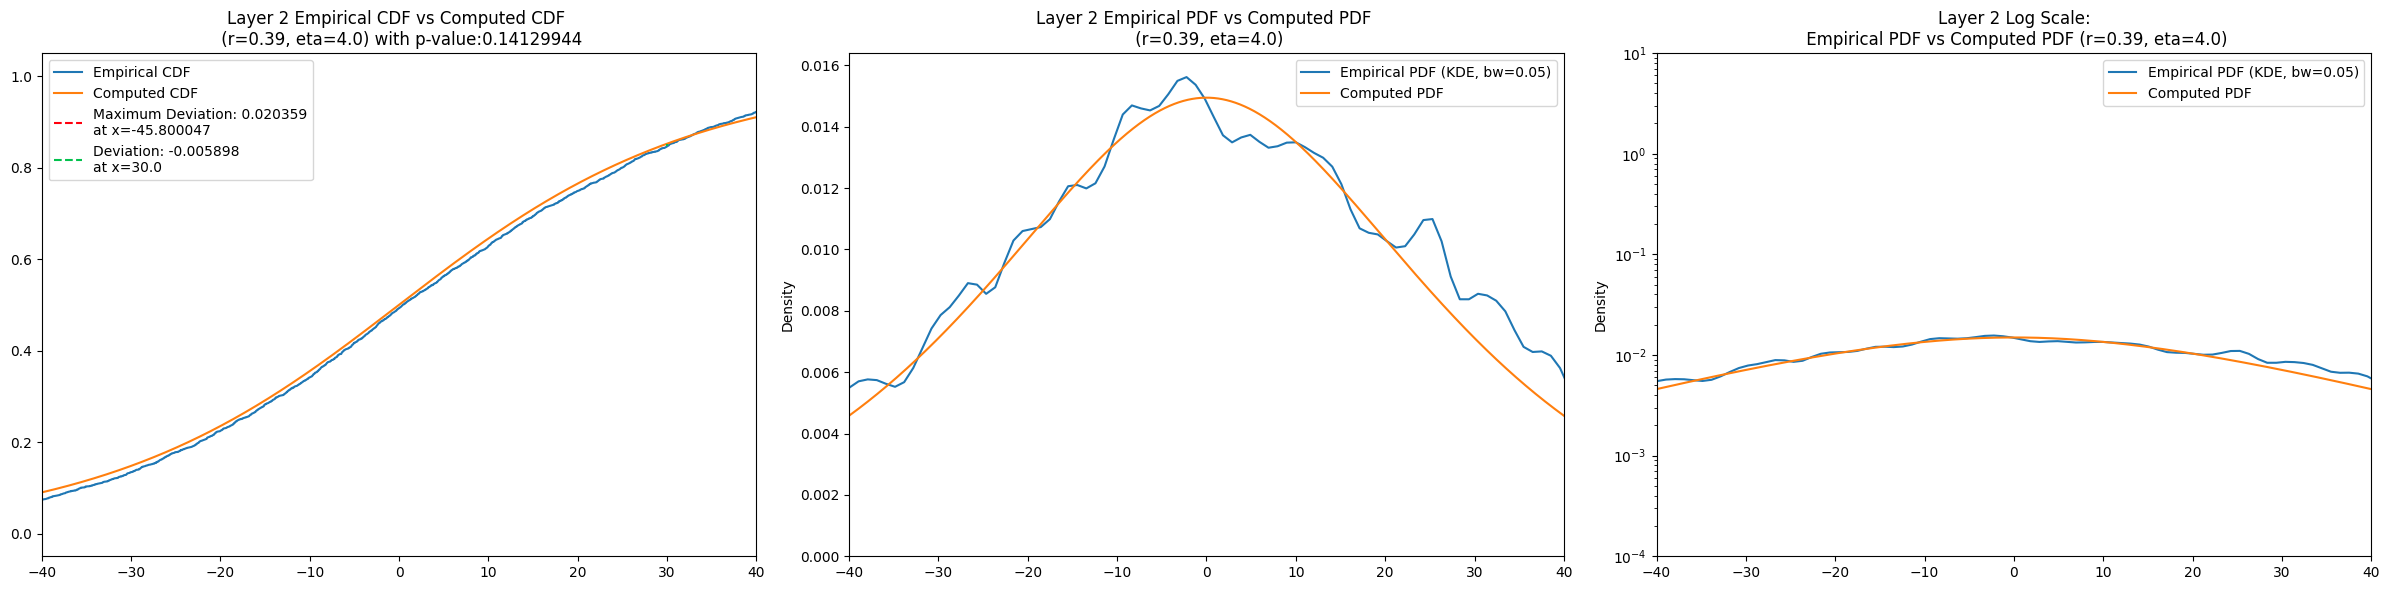

No tail
Chebyshev bound: 78.46081890770525
First CDF value: 5.507148241361813e-07
Last CDF value: 0.9992916761941001
0, 1 padding bounds: 1000000.0


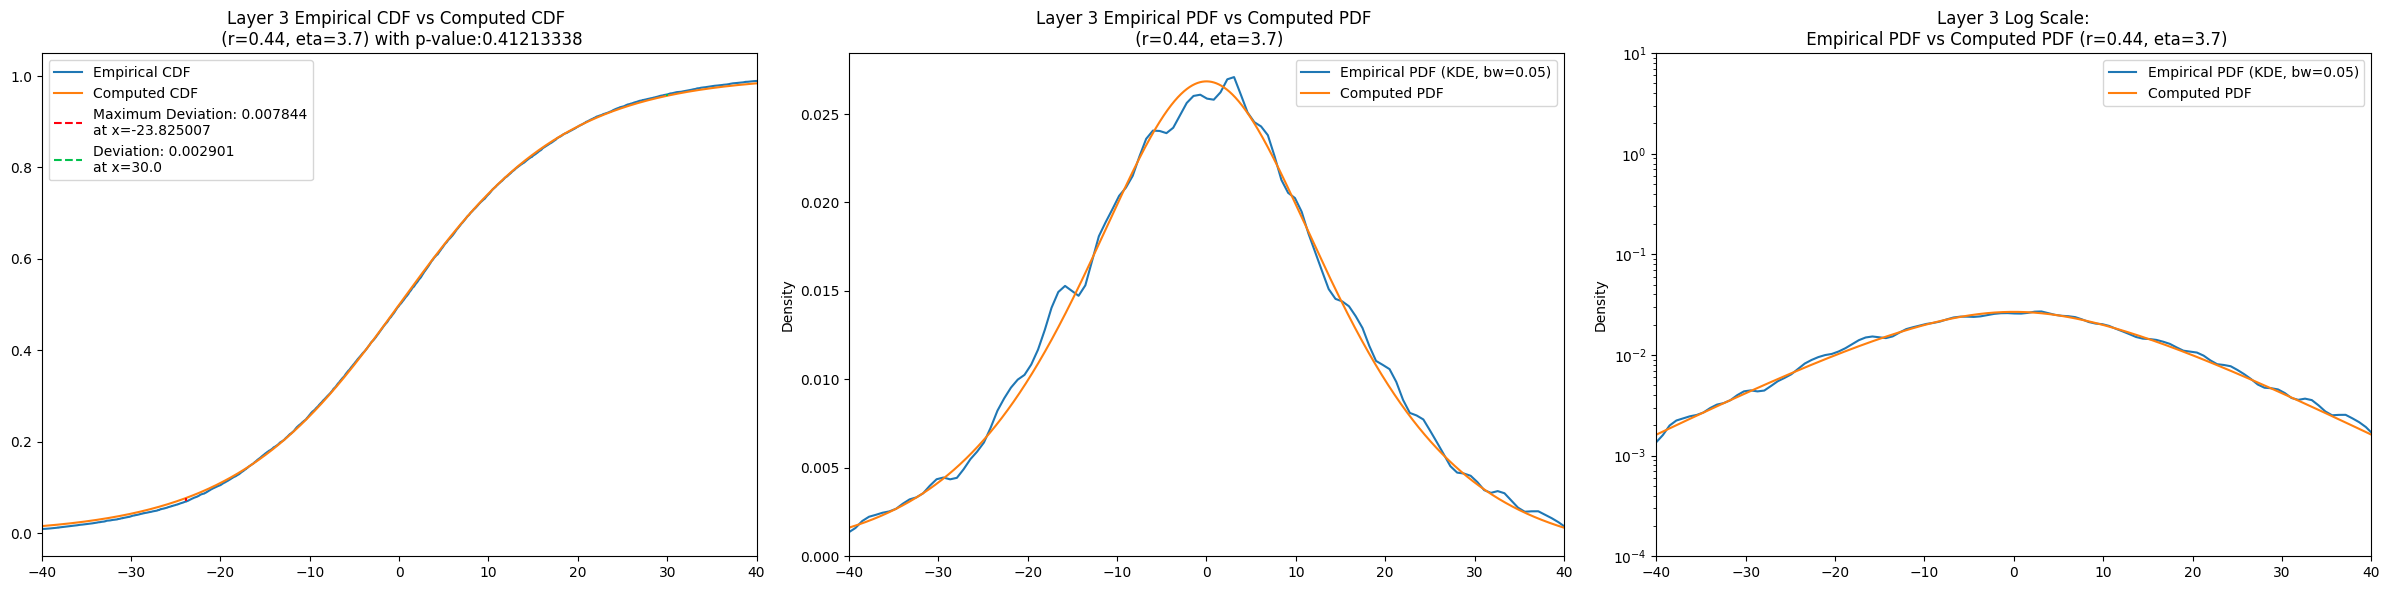

No tail
Chebyshev bound: 42.167304052604024
First CDF value: 9.697496609613425e-07
Last CDF value: 0.9984281058333783
0, 1 padding bounds: 1000000.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:87: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  prior_pdf[j] = integrate.quad(integrand, 0, np.inf)[0]


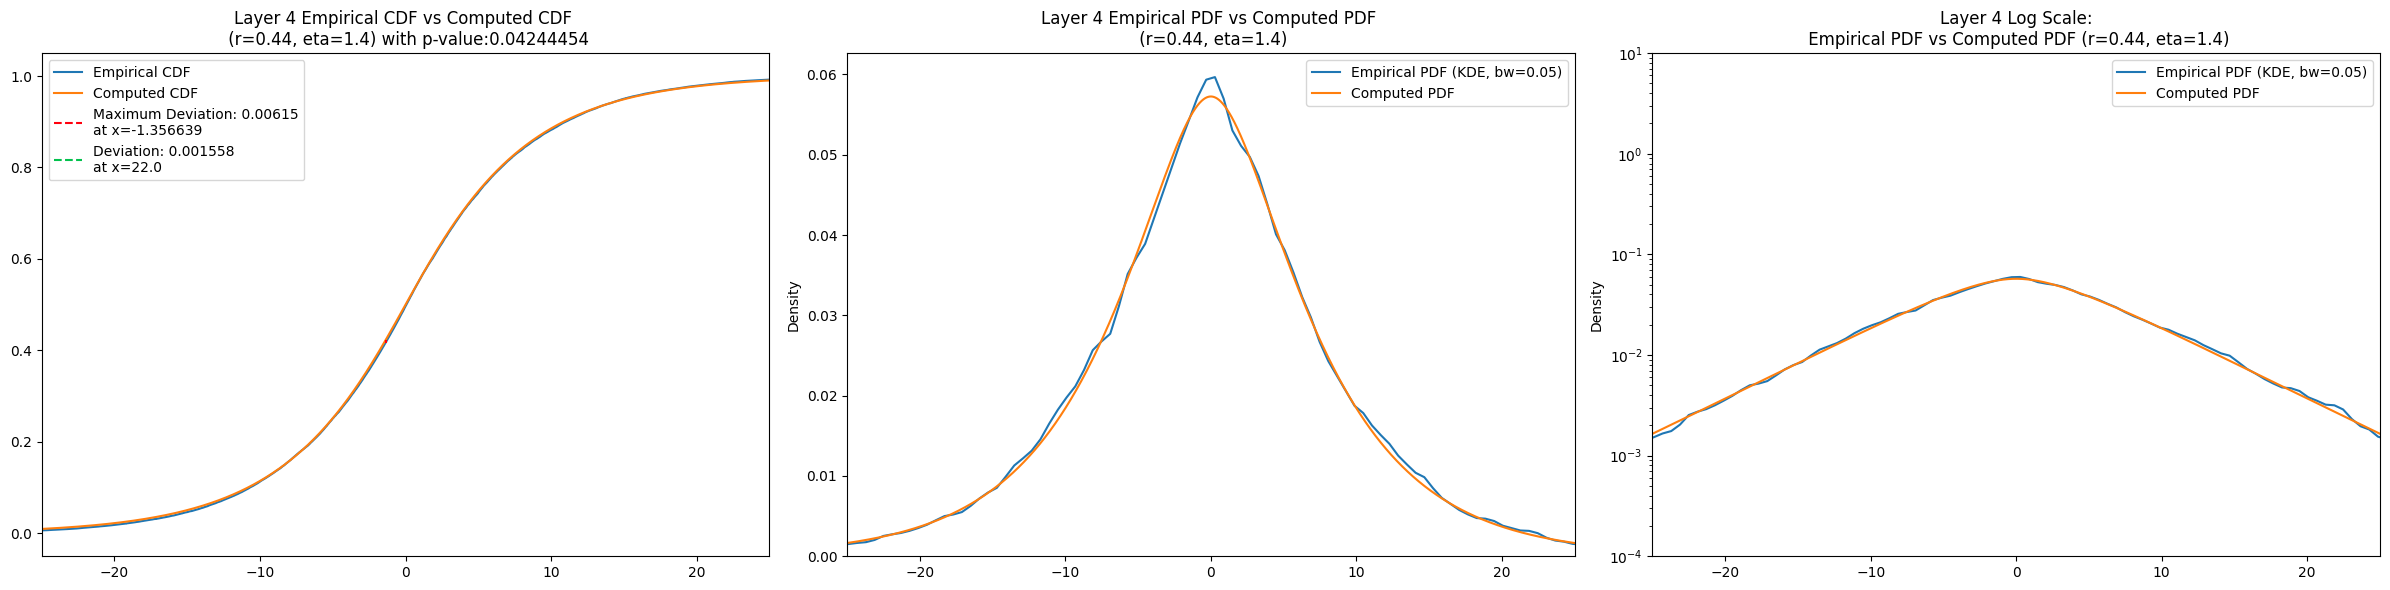

No tail
Chebyshev bound: 20.300820925496282
First CDF value: 1.3849825754018901e-06
Last CDF value: 0.9973242174031235
0, 1 padding bounds: 1000000.0


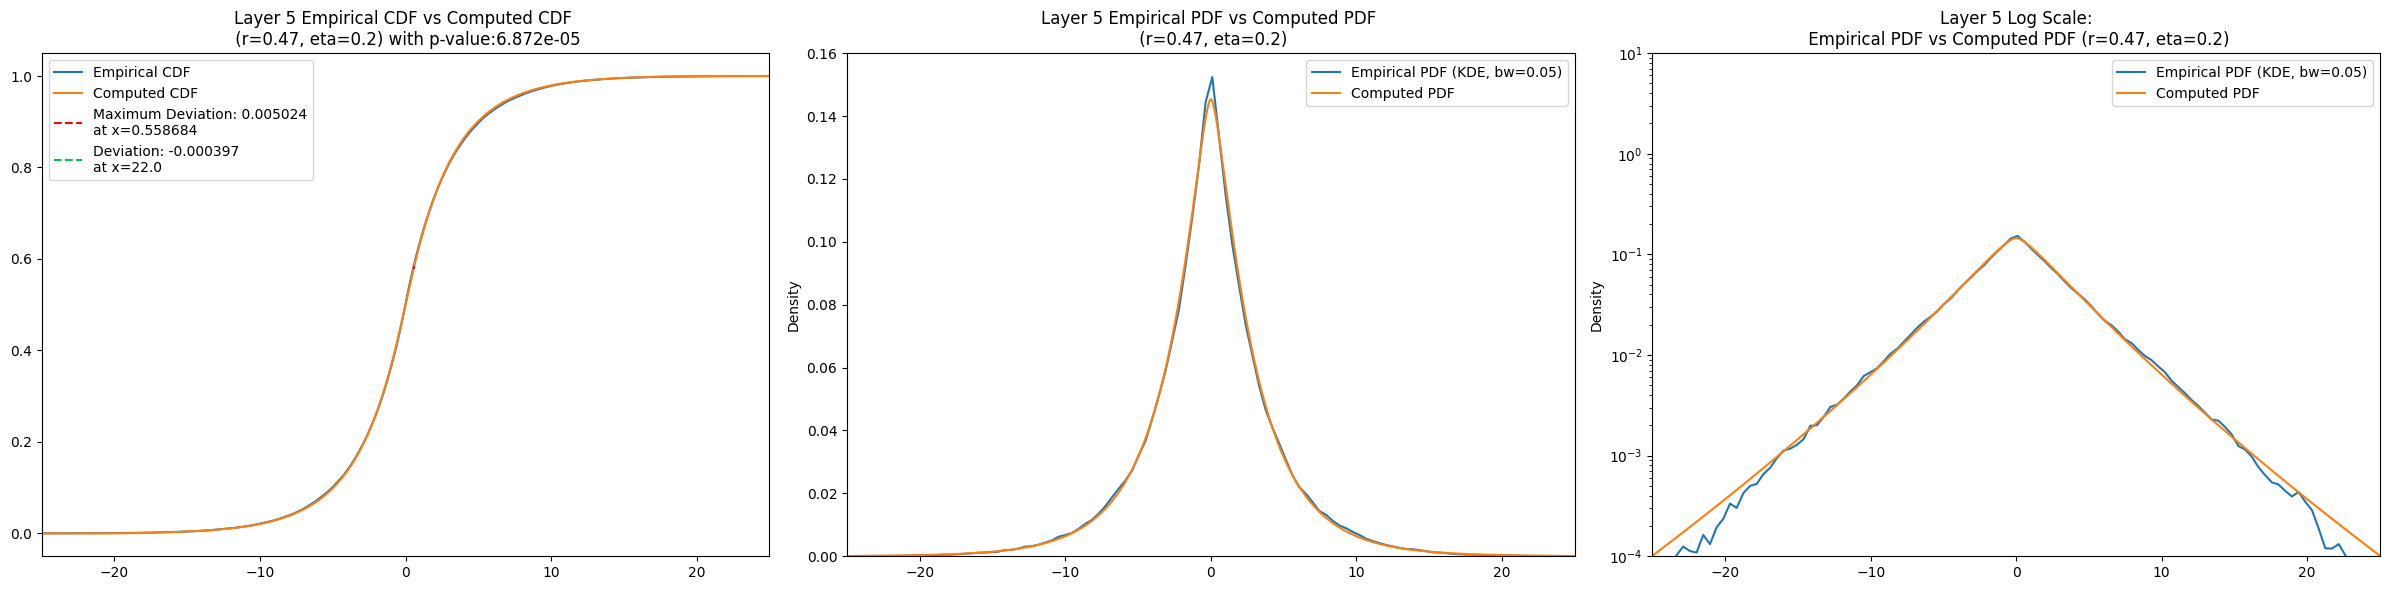

No tail
Chebyshev bound: 7.588825747498706
First CDF value: 1.0410903279315122e-06
Last CDF value: 0.9983483436317541
0, 1 padding bounds: 1000000.0


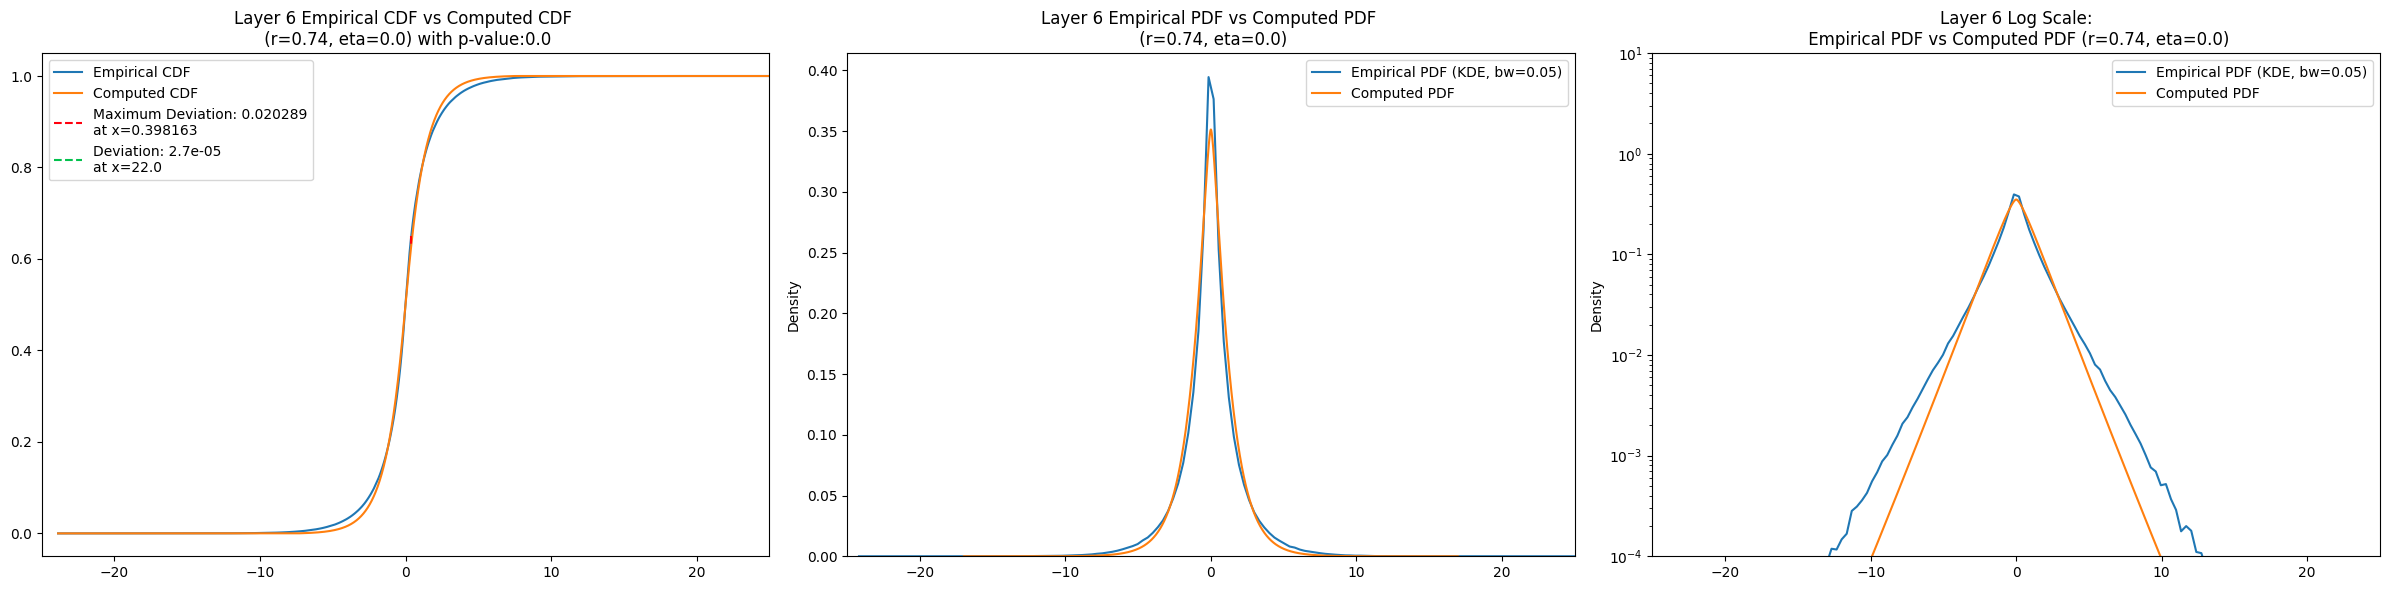

No tail
Chebyshev bound: 3.424770589780717
First CDF value: 1.7854618806850398e-07
Last CDF value: 0.9998619918291485
0, 1 padding bounds: 1000000.0


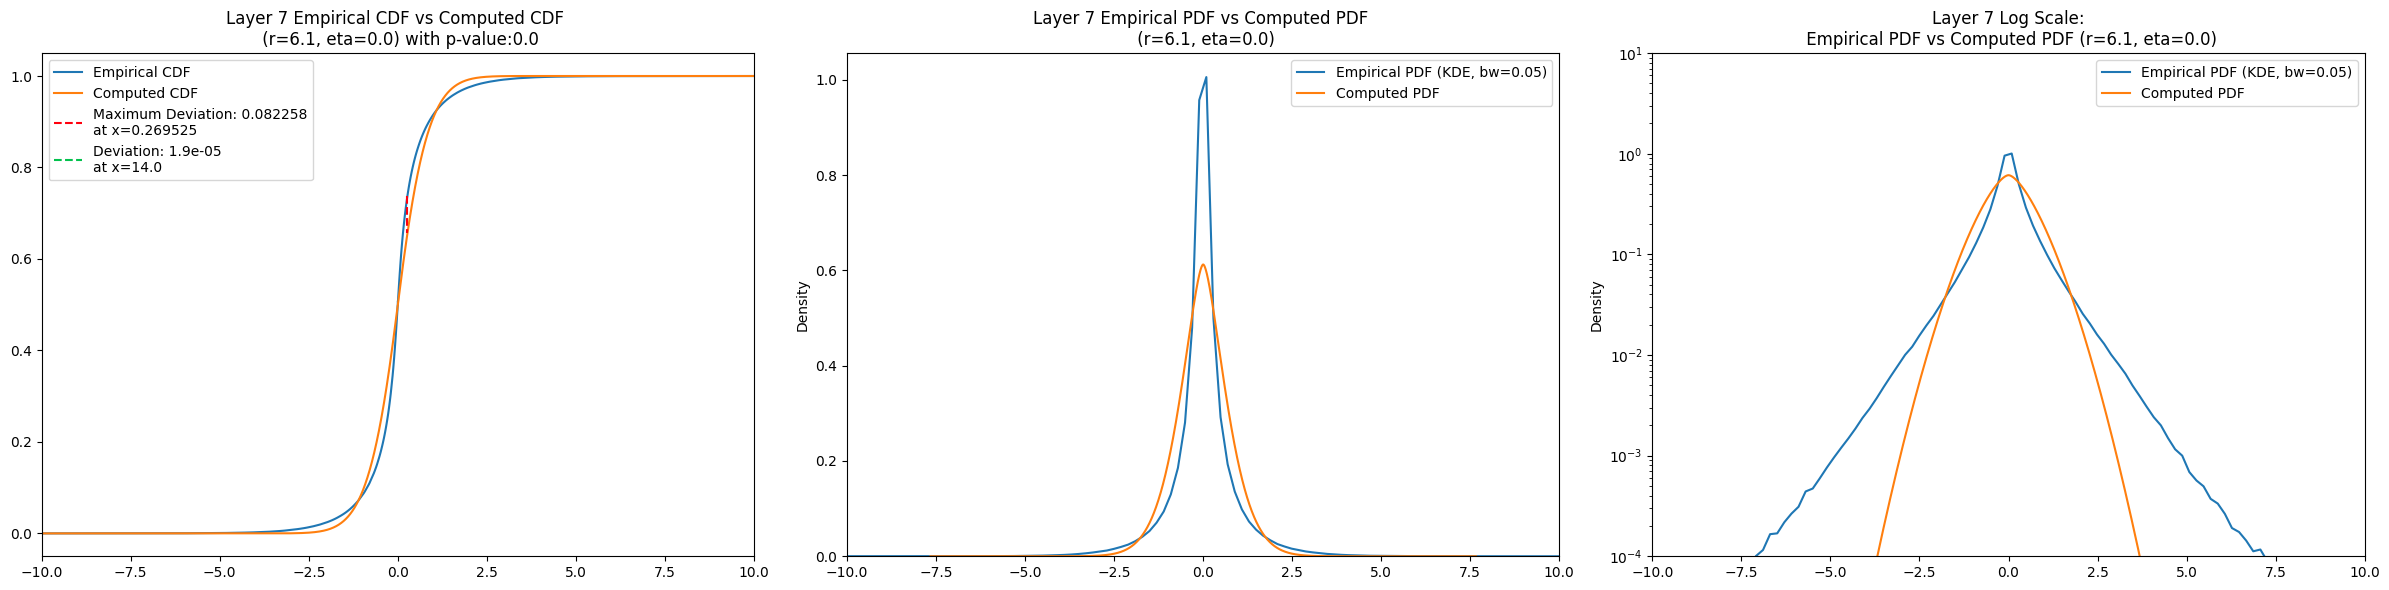

No tail
Chebyshev bound: 3.4258241645696366
First CDF value: 1.7980729374092142e-07
Last CDF value: 0.9998606913119513
0, 1 padding bounds: 1000000.0


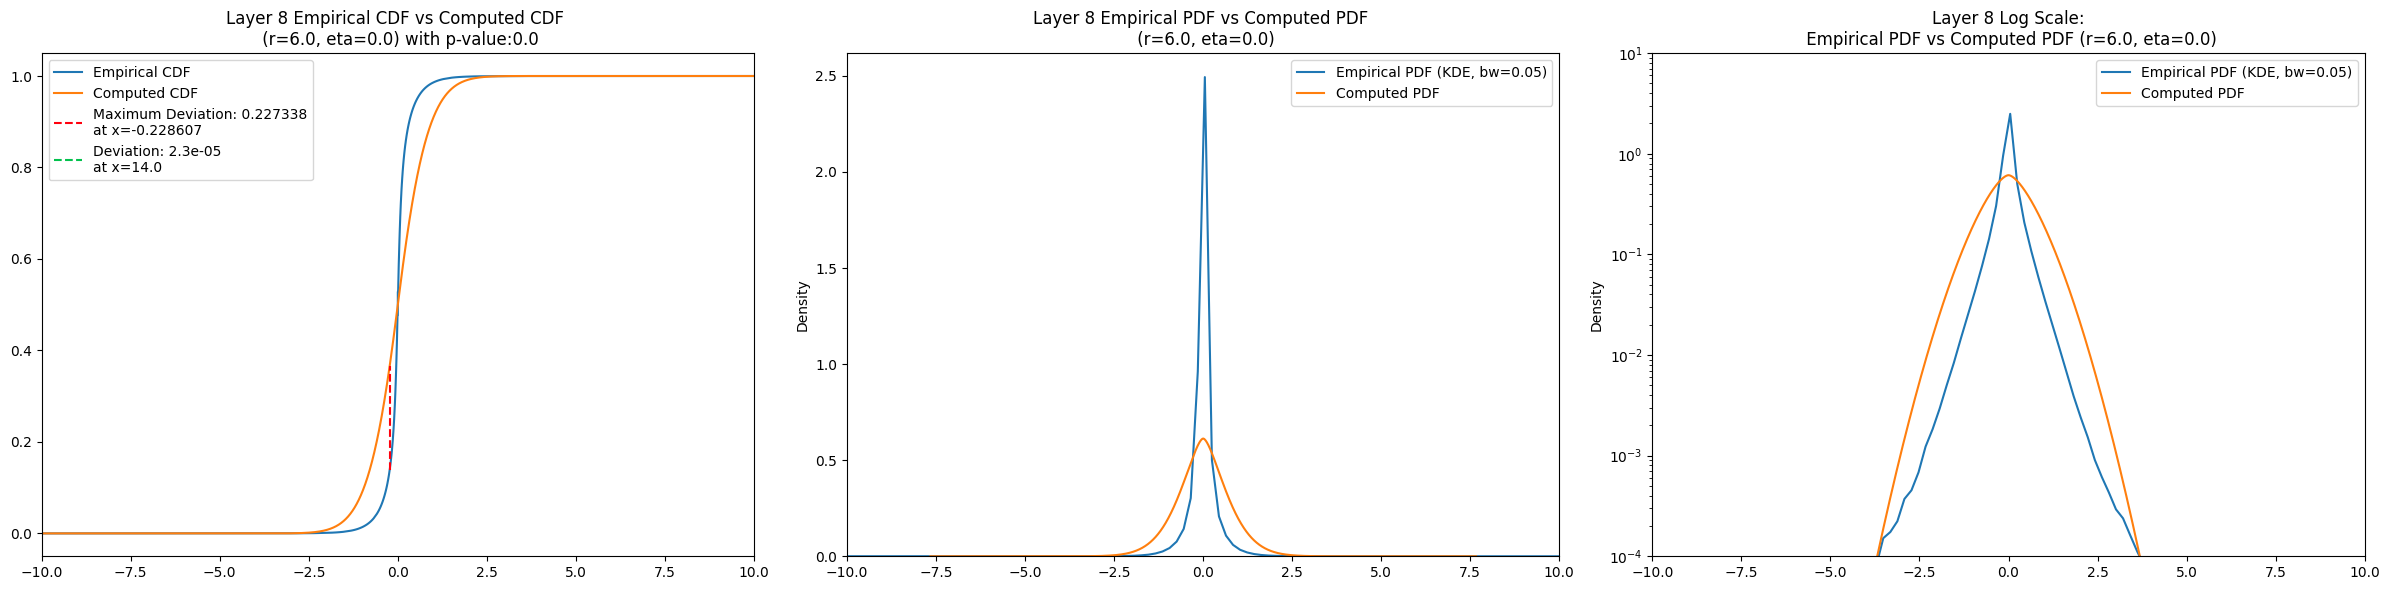

In [ ]:
for group in np.arange(min_group, max_group+1):
    group_info = master_df.loc[group]
    best_r = group_info[f'best_r']
    best_eta = group_info[f'best_eta']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta), 
                    log_scale = True,
                    all_cdfs = all_cdfs,
                    group = group,
                    interval = (-(40 - group//3.1*15), (40 - group//3.1*15)),
                    provided_loc=(30 - group//3.1*8))
    fig.savefig(f'{DATA_NAME}/plots/compare_cdf_pdf_layer_{group}.png', bbox_inches = 'tight')

## Comparing with Gaussian and Laplace

In [ ]:
for group in np.arange(min_group, max_group+1):
    norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, 50))
    laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, 50))
    t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, 50))
    
    master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
    master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

    master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
    master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

    master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(min(master_df.loc[group, 'kstest_stat_cd'], master_df.loc[group, 'kstest_stat_cd_scipy'])), 6)

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_compare_priors.csv')
master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_compare_priors.csv', index_col = GROUP)
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd,best_r_d2,best_eta_d1,n_pval_0.05,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,3180,"(0.39, 4.0)",0.021670,"(0.26, 0)",0.060374,0.024030,0.021670,0.39,4.0,4023,...,27.782300,0.019503,1.755550e-01,25.439100,0.036392,4.282210e-04,20.752800,0.036305,4.458110e-04,9.945980e-02
3,12720,"(0.44, 3.7)",0.008143,"(0.29, 0)",0.037031,0.012029,0.008143,0.44,3.7,28620,...,16.031400,0.010128,1.460870e-01,14.012900,0.022665,4.151010e-06,11.277100,0.026410,3.854630e-08,3.658630e-01
4,50880,"(0.44, 1.4)",0.006270,"(0.34, 0)",0.023245,0.006018,0.006270,0.44,1.4,48295,...,8.001070,0.020474,5.852830e-19,7.104980,0.014498,1.017140e-09,5.719650,0.018489,1.538450e-15,3.644850e-02
5,203520,"(0.47, 0.2)",0.005235,"(0.44, 0)",0.005645,0.003010,0.005235,0.47,0.2,64395,...,3.590120,0.030175,2.012920e-161,3.138820,0.002343,2.134870e-01,2.574020,0.010572,3.454100e-20,2.856240e-05
6,814080,"(0.74, 0.0)",0.020505,"(0.74, 0)",0.020505,0.001505,0.020505,0.74,0.0,4525,...,1.426170,0.042370,0.000000e+00,1.246790,0.014477,1.233750e-148,1.010520,0.017937,5.988230e-228,9.489030e-298
7,3256320,"(6.1, 0.0)",0.082279,"(6.1, 0)",0.082279,0.000753,0.082279,6.10,0.0,279,...,0.539642,0.052925,0.000000e+00,0.472750,0.025277,0.000000e+00,0.378316,0.026436,0.000000e+00,0.000000e+00
8,13025280,"(6.0, 0.0)",0.227356,"(6.0, 0)",0.227356,0.000376,0.227356,6.00,0.0,36,...,0.196018,0.056353,0.000000e+00,0.172564,0.029150,0.000000e+00,0.137348,0.028144,0.000000e+00,0.000000e+00


# Examining Tail Behavior

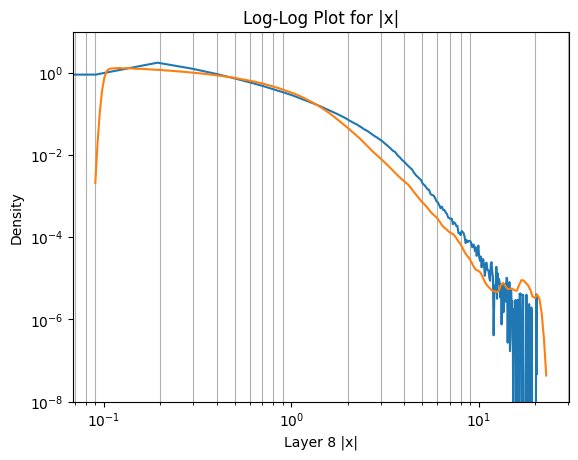

In [ ]:
bw = 0.05
group = 7
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(f'{DATA_NAME}/plots/log-log_plot_layer_7.png', bbox_inches = 'tight')

bw = 0.05
group = 8
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(f'{DATA_NAME}/plots/log-log_plot_layer_8.png', bbox_inches = 'tight')


In [ ]:
def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
    if metric_name == 'kstest_ratio':
        metric = compute_ksratio
    elif metric_name == 'kstest_stat':
        metric = compute_ksstat_tail

    for tail_cutoff in tail_cutoffs:
        metrics = []
        for layer in layers:
            if distro == 'gengamma':
                cdf = all_cdfs[master_df.loc[layer, 'initial_param']]
            elif distro == 'gaussian':
                cdf = stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
            elif distro == 'laplace':
                cdf = stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
            elif distro == 't':
                cdf = stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
            metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
        master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
for group in np.arange(min_group, max_group+1):
    add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
    add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df.csv')

master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd,best_r_d2,best_eta_d1,n_pval_0.05,...,kstest_ratio_gengamma_tail0,kstest_ratio_gengamma_tail10,kstest_ratio_gaussian_tail0,kstest_ratio_gaussian_tail10,kstest_ratio_laplace_tail0,kstest_ratio_laplace_tail10,kstest_ratio_t_tail0,kstest_ratio_t_tail10,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
layer,,,,,,,,,,,,,,,,,,,,,
2,3180,"(0.39, 4.0)",0.021670,"(0.26, 0)",0.060374,0.024030,0.021670,0.39,4.0,4023,...,"(0.082446, 1.0161)","(0.082446, 1.0161)","(0.9368, 1.9545)","(0.9368, 1.9545)","(0.95089, 7.3557)","(0.95089, 7.3557)","(0.015521, 1.04)","(0.015521, 1.04)",0.021670,2.166960e-02
3,12720,"(0.44, 3.7)",0.008143,"(0.29, 0)",0.037031,0.012029,0.008143,0.44,3.7,28620,...,"(0.095485, 1.0197)","(0.095485, 1.0197)","(0.96671, 76.943)","(0.96671, 76.943)","(0.96151, 2839.9)","(0.96151, 2839.9)","(0.0074015, 1.1147)","(0.0074015, 1.1147)",0.008143,8.143188e-03
4,50880,"(0.44, 1.4)",0.006270,"(0.34, 0)",0.023245,0.006018,0.006270,0.44,1.4,48295,...,"(0.099159, 1.0029)","(0.099159, 1.0029)","(0.93633, 391120.0)","(0.97872, 391120.0)","(0.95756, 119260000.0)","(0.95756, 119260000.0)","(0.003275, 1.0744)","(0.003275, 1.0176)",0.005811,5.486526e-03
5,203520,"(0.47, 0.2)",0.005235,"(0.44, 0)",0.005645,0.003010,0.005235,0.47,0.2,64395,...,"(0.26455, 3376.1)","(0.26455, 3376.1)","(0.90723, 9.236e+34)","(0.98075, 9.236e+34)","(0.95007, 9.254e+46)","(0.97884, 9.254e+46)","(0.0034259, 1.0662)","(0.0034259, 1.0104)",0.003321,1.373036e-03
6,814080,"(0.74, 0.0)",0.020505,"(0.74, 0)",0.020505,0.001505,0.020505,0.74,0.0,4525,...,"(0.94647, 1556300.0)","(0.99916, 1556300.0)","(0.87957, 3.725e+56)","(0.99905, 3.725e+56)","(0.93638, 2.5142e+75)","(0.99905, 2.5142e+75)","(0.0013751, 1.2182)","(0.0013751, 1.0041)",0.019262,8.376645e-04
7,3256320,"(6.1, 0.0)",0.082279,"(6.1, 0)",0.082279,0.000753,0.082279,6.10,0.0,279,...,"(0.72838, 34048000000000.0)","(0.99998, 12787000000.0)","(0.85009, 2.0712000000000005e+268)","(0.99998, 2.0712000000000005e+268)","(0.90639, inf)","(0.99998, inf)","(0.0015714, 1.506)","(0.0015714, 1.0007)",0.016792,2.426051e-05
8,13025280,"(6.0, 0.0)",0.227356,"(6.0, 0)",0.227356,0.000376,0.227356,6.00,0.0,36,...,"(0.13028, 69281000000.0)","(1.0, 180970000.0)","(0.83652, inf)","(1.0, inf)","(0.89531, inf)","(1.0, inf)","(0.0028504, 1.7139)","(0.0028504, 1.0001)",0.006479,7.677378e-07


# Results

## KS-Test Statistics

In [ ]:
#master_df.filter(regex='num_samples|kstest_stat.*')
#master_df.filter(regex='num_samples|param.*')
# master_df.filter(regex='.*gaussian')
master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,kstest_stat_initial,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd_scipy,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
layer,,,,,,,,,
2,0.021670,0.060374,0.024030,0.021670,0.019503,0.036392,0.036305,0.021670,2.166960e-02
3,0.008143,0.037031,0.012029,0.008143,0.010128,0.022665,0.026410,0.008143,8.143188e-03
4,0.006270,0.023245,0.006018,0.006270,0.020474,0.014498,0.018489,0.005811,5.486526e-03
5,0.005235,0.005645,0.003010,0.005235,0.030175,0.002343,0.010572,0.003321,1.373036e-03
6,0.020505,0.020505,0.001505,0.020505,0.042370,0.014477,0.017937,0.019262,8.376645e-04
7,0.082279,0.082279,0.000753,0.082279,0.052925,0.025277,0.026436,0.016792,2.426051e-05
8,0.227356,0.227356,0.000376,0.227356,0.056353,0.029150,0.028144,0.006479,7.677378e-07
